In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=3072)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)



device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

import os
import seaborn as sns
import keras
import tqdm

from tensorflow.keras import layers
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.preprocessing.image import save_img, load_img
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

1 Physical GPUs, 1 Logical GPUs
Found GPU at: /device:GPU:0


In [3]:
print(tf.__version__)


2.8.3


In [4]:
class CFG:
    BATCH_SIZE = 32
    SEED = 40
    HEIGHT = 224
    WIDTH = 224
    CHANNELS = 3
    IMAGE_SHAPE = (224,224 ,3 )

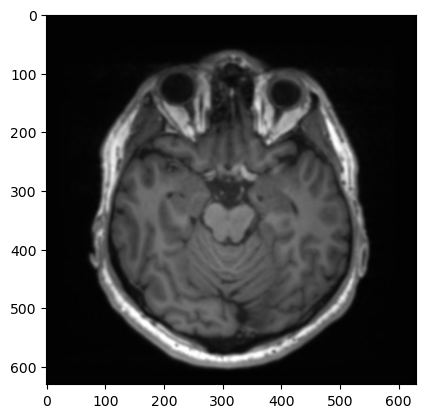

In [5]:
raw_img = plt.imread(os.path.normpath("C:\\Users\\deniz\\Desktop\\45class\\_NORMAL T1\\0a0bc6879f5d5d14c4df229b64b801_big_gallery.jpeg"))
plt.imshow(raw_img,cmap='gray')

In [6]:
import cv2

def crop_mri(path):
    image = cv2.imread(path)

    #Orijinal görüntüyü gri tonlamaya çevirme
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #Threshold uygulama
    _, thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)

    #kontur bulma
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)

    #Görüntüyü sadece en büyük konturun etrafında kırpma
    x, y, w, h = cv2.boundingRect(largest_contour)
    cropped_image = image[y:y+h, x:x+w]

    return cropped_image

# Fotoğrafların klasörlerinden ayrıştırılması, labellanması ve kırpılması

In [7]:
data = []
labels = []
source_path = "C:\\Users\\deniz\\Desktop\\45class"
dest_path = "C:\\Users\\deniz\\Desktop\\15Class\\data"

from tqdm import tqdm

for fold in tqdm(os.listdir(source_path)):
    tumor_type = fold.split()[0]

    if labels.count(tumor_type) == 0:
        labels.append(tumor_type)

    tumor_fold = os.path.join(source_path,fold)
    for image in os.listdir(tumor_fold):
        image_path = os.path.join(tumor_fold,image)

        dest = os.path.join(dest_path,image)
        if(os.path.exists(dest)==False):
          cropped_img = crop_mri(image_path)
          save_img(dest,cropped_img)
        data.append({'image_path':dest,'tumor_type':labels.index(tumor_type)})

df = pd.DataFrame(data)
df = df.sample(frac=1).reset_index(drop=True) # Shuffle

print(labels)

df.head()

100%|██████████| 44/44 [02:06<00:00,  2.87s/it]

['Astrocitoma', 'Carcinoma', 'Ependimoma', 'Ganglioglioma', 'Germinoma', 'Glioblastoma', 'Granuloma', 'Meduloblastoma', 'Meningioma', 'Neurocitoma', 'Oligodendroglioma', 'Papiloma', 'Schwannoma', 'Tuberculoma', '_NORMAL']


,image_path,tumor_type
0,C:\Users\deniz\Desktop\15Class\data\248ee7e5e1...,12
1,C:\Users\deniz\Desktop\15Class\data\3af3811f03...,12
2,C:\Users\deniz\Desktop\15Class\data\2fedf084f1...,14
3,C:\Users\deniz\Desktop\15Class\data\2022-05-28...,8
4,C:\Users\deniz\Desktop\15Class\data\a3b6ded68f...,0


<AxesSubplot:>

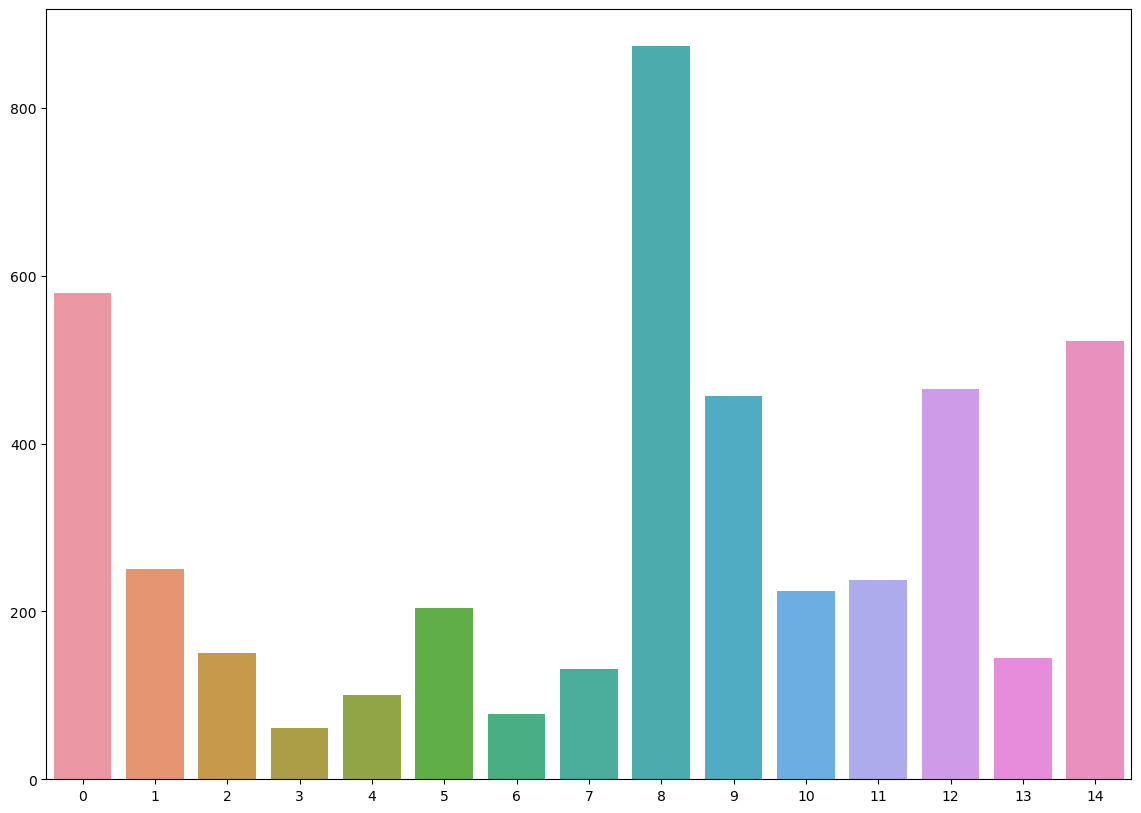

In [7]:
fig = plt.figure(figsize=(14, 10))

sorted_distr = df['tumor_type'].value_counts().sort_values()
sns.barplot(y = sorted_distr.values,x = list(sorted_distr.keys()))

Dataset oldukça dengesiz..

In [8]:
#Seti 3'e ayırıyorum
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_df, val_df = train_test_split(train_df, test_size=0.125, random_state=42) # %10 validation

In [9]:
generate_counts = {}
max_count = len(train_df['tumor_type'][train_df['tumor_type'] == labels.index('Meningioma')])
print(str(max_count))
for label in labels:
    generate_counts[label] = 0
    generate_counts[label] = max_count - len(train_df['tumor_type'][train_df['tumor_type'] == labels.index(label)])

603


Dengesizliği kaldırmak için her class için ne kadar görüntü daha gerekiyor..

In [10]:
print(generate_counts)

{'Astrocitoma': 212, 'Carcinoma': 429, 'Ependimoma': 491, 'Ganglioglioma': 558, 'Germinoma': 531, 'Glioblastoma': 449, 'Granuloma': 546, 'Meduloblastoma': 506, 'Meningioma': 0, 'Neurocitoma': 278, 'Oligodendroglioma': 440, 'Papiloma': 433, 'Schwannoma': 289, 'Tuberculoma': 508, '_NORMAL': 225}


In [10]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1,fill_mode='constant'),
])

0 ile 0.1 * 2pi arasında döndürme ve yatay çevirme uygulanır.

In [11]:
from PIL import Image
import math

save_dir = "C:\\Users\\deniz\\Desktop\\15Class\\data"

import warnings
warnings.filterwarnings("ignore")


for label in labels:
    i = 0
    #pbar.set_description(f"{label} verileri arttırılıyor  ")
    coefficent = math.ceil(generate_counts[label] /(train_df['tumor_type'] == labels.index(label)).sum())

    print(f'{label} verileri arttırılıyor..')
    for image_path in train_df['image_path'][train_df['tumor_type'] == labels.index(label)]:
        img = load_img(image_path)
        img = img_to_array(img)

        img = tf.expand_dims(img, 0)


        for j in range(coefficent):
            augmented_image = data_augmentation(img)


            i = i+1
            save_path = os.path.join(save_dir, f'{label}_{i}.jpeg')
            if(os.path.exists(save_path)==False):
              augmented_image = tf.squeeze(augmented_image, axis=0)
              save_img(save_path,augmented_image)

            new_row = {'image_path':save_path, 'tumor_type':labels.index(label)}

            train_df = pd.concat([train_df, pd.DataFrame([new_row])], ignore_index=True)

print("Tamamlandı.") /home/denizceylan/enter/bin/conda

Astrocitoma verileri arttırılıyor..
Carcinoma verileri arttırılıyor..
Ependimoma verileri arttırılıyor..
Ganglioglioma verileri arttırılıyor..
Germinoma verileri arttırılıyor..
Glioblastoma verileri arttırılıyor..
Granuloma verileri arttırılıyor..
Meduloblastoma verileri arttırılıyor..
Meningioma verileri arttırılıyor..
Neurocitoma verileri arttırılıyor..
Oligodendroglioma verileri arttırılıyor..
Papiloma verileri arttırılıyor..
Schwannoma verileri arttırılıyor..
Tuberculoma verileri arttırılıyor..
_NORMAL verileri arttırılıyor..
Tamamlandı.


<AxesSubplot:>

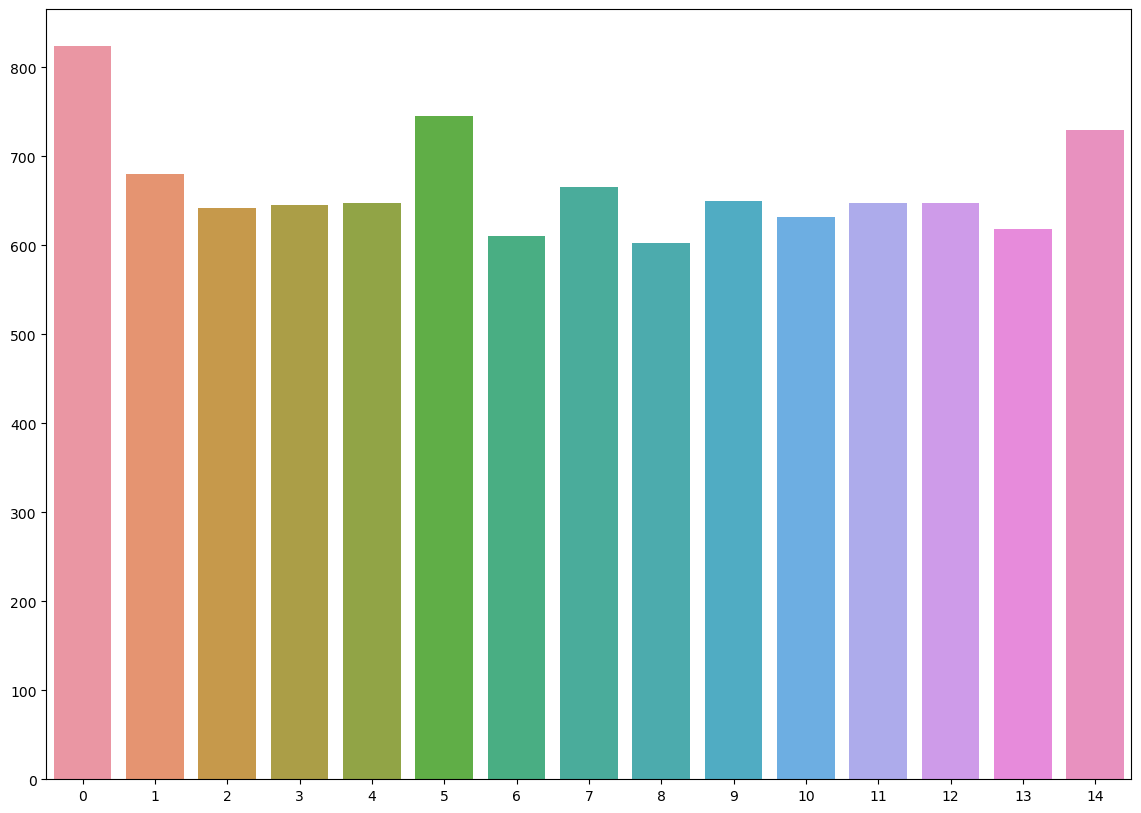

In [12]:
fig = plt.figure(figsize=(14, 10))

sorted_distr = train_df['tumor_type'].value_counts().sort_values()
sns.barplot(y = sorted_distr.values,x = list(sorted_distr.keys()))

Artık daha iyi.

In [14]:
train_df['tumor_type'].value_counts()

0     780
14    754
1     692
11    676
7     672
2     666
13    658
9     648
10    648
4     639
12    626
3     616
6     616
5     612
8     602
Name: tumor_type, dtype: int64

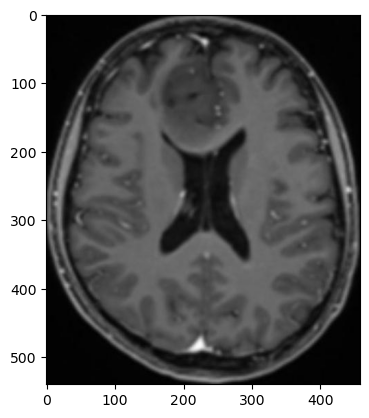

In [13]:
sample_img = train_df['image_path'][50]
raw_image = plt.imread(sample_img)

plt.imshow(raw_image,cmap='gray')

In [14]:
def show_image_pix_distr(image):
    sns.displot(image.ravel(),
                 label=f'Piksel ort. {np.mean(image):.4f} & Standart sapma {np.std(image):.4f}', kde=False)
    plt.legend(loc='upper center')
    plt.title('Piksel yoğunluk dağılımı')
    plt.xlabel('Piksel değeri')
    plt.ylabel('Piksel sayısı')

Piksel değer ortalaması 0'dan standart sapması ise 1'den epey epey uzak.

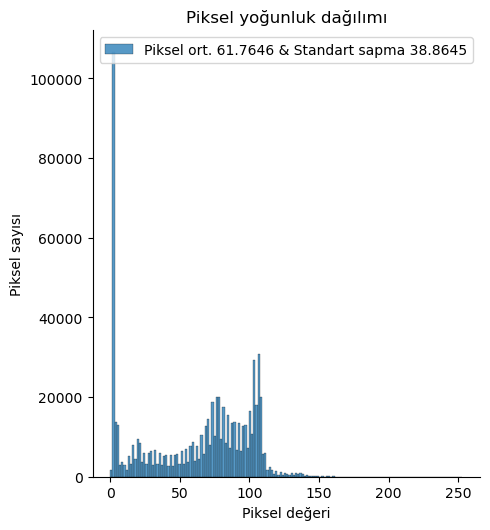

In [15]:
show_image_pix_distr(raw_image)

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [17]:
def get_train_generator(df,shuffle=True, batch_size=8, seed=1):
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)

    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            x_col="image_path",
            y_col= 'tumor_type',
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(CFG.HEIGHT,CFG.WIDTH))
    return generator

Tüm verilere normalizasyon train setteki batch ortalama ve standart sapma verileriyle yapılır. Bunun nedeni gerçek hayat seneryosunda elimize gelen fotoğrafları teker teker inceleyeceğiz ve batch istatistiklerini bilmiyor olacağız.

Modele test setin istatiklerini vererek ona kolaylık tanımamış oluyoruz..

In [18]:
def get_test_and_valid_generator(valid_df, test_df, train_df, sample_size=100, batch_size=8, seed=1):

    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df,
        x_col="image_path",
        y_col= 'tumor_type',
        class_mode="raw",
        batch_size=sample_size,
        shuffle=True,
        target_size=(CFG.HEIGHT,CFG.WIDTH))

    # train sampledan batch istatistikleri için örnek alınır..
    batch = raw_train_generator.__next__()
    data_sample = batch[0]

    # test generatorü
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)

    image_generator.fit(data_sample)

    # test gen
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            x_col="image_path",
            y_col= 'tumor_type',
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(CFG.HEIGHT,CFG.WIDTH))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            x_col="image_path",
            y_col= 'tumor_type',
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(CFG.HEIGHT,CFG.WIDTH))
    return valid_generator, test_generator

ImageGenerator sınıfıyla normalizasyon yapılır. Bu T1,T2,T1C+ gibi farklı MRI görüntüleme tiplerini piksel değerleri normalize ederek performansı arttırır.

In [19]:
train_generator = get_train_generator(train_df)
valid_generator, test_generator= get_test_and_valid_generator(val_df, test_df, train_df)

Found 9988 validated image filenames.
Found 9988 validated image filenames.
Found 448 validated image filenames.
Found 896 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Raw Chest X Ray Image')

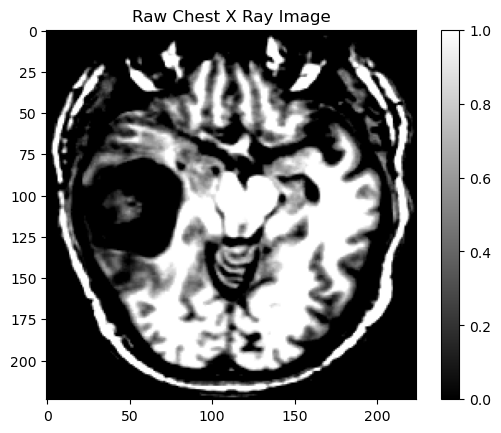

In [20]:
generated_image, label = train_generator.__getitem__(511)
plt.imshow(generated_image[0], cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')

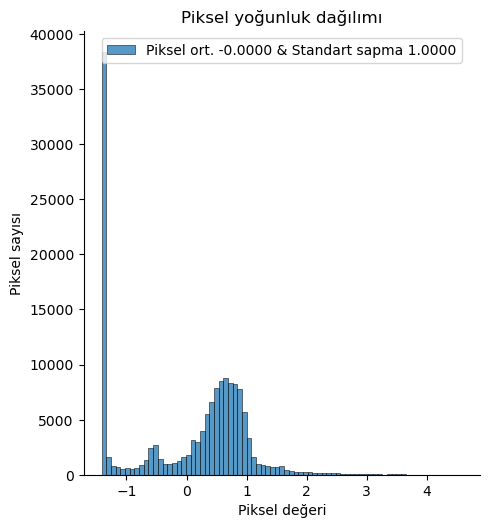

In [22]:
show_image_pix_distr(generated_image[0])

Normalize olmuş fotoğrafımızın piksel density dağılımı

In [21]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

base_model = tf.keras.applications.efficientnet.EfficientNetB5(include_top= False, weights= "imagenet", input_shape= CFG.IMAGE_SHAPE, pooling= 'max')

fine_tune_at = 100

label_counts = len(labels)

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(label_counts, activation= 'softmax')
])

model.compile(Adam(learning_rate= 0.001), loss= 'sparse_categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional)  (None, 2048)             28513527  
                                                                 
 batch_normalization (BatchN  (None, 2048)             8192      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 15)                3855      
                                                                 
Total params: 29,050,118
Trainable params: 28,873,279
Non-trainable params: 176,839
____________________________________

In [ ]:
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

In [22]:
history = model.fit(x= train_generator, epochs= 32, verbose= 2,
                    validation_data= valid_generator, validation_steps= None, shuffle= False)

Epoch 1/32


ResourceExhaustedError: Graph execution error:

Detected at node 'gradient_tape/sequential_1/efficientnetb5/block7c_project_conv/Conv2D/Conv2DBackpropInput' defined at (most recent call last):
    File "c:\Users\deniz\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\deniz\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\deniz\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\deniz\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\Users\deniz\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\deniz\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\deniz\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\deniz\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\deniz\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\deniz\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\deniz\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\deniz\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\deniz\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\deniz\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "c:\Users\deniz\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\deniz\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2914, in run_cell
      result = self._run_cell(
    File "c:\Users\deniz\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "c:\Users\deniz\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\deniz\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\deniz\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "c:\Users\deniz\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\deniz\AppData\Local\Temp\ipykernel_21996\4090845193.py", line 1, in <module>
      history = model.fit(x= train_generator, epochs= 32, verbose= 2,
    File "c:\Users\deniz\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\deniz\anaconda3\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\deniz\anaconda3\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "c:\Users\deniz\anaconda3\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\deniz\anaconda3\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "c:\Users\deniz\anaconda3\lib\site-packages\keras\engine\training.py", line 863, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "c:\Users\deniz\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 530, in minimize
      grads_and_vars = self._compute_gradients(
    File "c:\Users\deniz\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 583, in _compute_gradients
      grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
    File "c:\Users\deniz\anaconda3\lib\site-packages\keras\optimizer_v2\optimizer_v2.py", line 464, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/sequential_1/efficientnetb5/block7c_project_conv/Conv2D/Conv2DBackpropInput'
OOM when allocating tensor with shape[8,3072,7,7] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/sequential_1/efficientnetb5/block7c_project_conv/Conv2D/Conv2DBackpropInput}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_1187703]